### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util import numpy_support as vtk_np
import matplotlib.pyplot as plt
import gc

import sys

#add path
sys.path.insert(0, '../../src/simulator')     # import path/to/synthpy

import beam as beam_initialiser
import diagnostics as diag
import domain as d
import propagator as p
import utils

import importlib
importlib.reload(beam_initialiser)
importlib.reload(diag)
importlib.reload(d)
importlib.reload(p)
importlib.reload(utils)

<module 'utils' from '/home/administrator/Work/UROP_ICL_Internship/synthPy/examples/notebooks/../../src/simulator/utils.py'>

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [ ]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 128

#x = np.linspace(-extent_x, extent_x, n_cells)
#y = np.linspace(-extent_y, extent_y, n_cells)
#z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

print("Garbage collection count:", gc.collect())

#domain = d.ScalarDomain(x = x, y = y, z = z, extent = probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells) # B_on = False by default

# clear we should do manual garbage collection of some variety in d.ScalarDomain function
print("Garbage collection count:", gc.collect())

Garbage collection count: 4870
Garbage collection count: 0


Load some domain distribution

In [ ]:
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

#domain.ne = np.full((100, 100, 100), 1e24)
domain.test_exponential_cos()
#domain.test_slab(0.000001, 1e24)

Solve gradients, initialise beam, and solve

In [ ]:
lwl = 1064e-9 #define laser wavelength

# initialise beam
Np = 1e3    # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

beam_definition = beam_initialiser.Beam(Np, beam_size, divergence, ne_extent, probing_direction = probing_direction, wavelength = lwl, beam_type = beam_type)

tracer = p.Propagator(domain, beam_definition.s0, probing_direction = probing_direction, inv_brems = False, phaseshift = False)

# solve ray trace
tracer.calc_dndr(lwl)
# without the _, both rf and Jf (even though it defaults to None when return_E = False) get unpacked into rf and it becomes a tuple
rf, _ = tracer.solve(parallelise = True, jitted = True)
print("\nCompleted ray trace in", np.round(tracer.duration, 3), "seconds.")

72128
hi

Size in memory of initial rays: 70.4375KB

Default jax backend: cpu
Available devices: [CpuDevice(id=0)]
Running device: cpu, with: 16 cores.

jax compilation of solver took: 0.0013232231140136719


         
         
         
         
         
  CPU 0  
         
         
         
         
         

72128
hi

Size in memory of initial rays: 70.4375KB
48
Size in memory of solution: 48B
48
Size in memory of propagator class: 48B
File: ls
Type: space
Showing nodes accounting for 690264.86kB, 100% of 690424.34kB total
Dropped 76 nodes (cum <= 3452.12kB)
      flat  flat%   sum%        cum   cum%
371199.93kB 53.76% 53.76% 526201.44kB 76.21%  apply_primitive
319064.88kB 46.21%   100% 319070.40kB 46.21%  __call__
    0.05kB 6.8e-06%   100% 163840.08kB 23.73%  deferring_binary_op
         0     0%   100% 690424.34kB   100%  [ls]
         0     0%   100%    40960kB  5.93%  _array_copy
         0     0%   100%    40960kB  5.93%  _copy_impl
         0     0%   100% 187992.88kB 27.23%  _pjit_call_impl_python
         0     0%   100% 690424.34kB   100%  _pseudo_sync_runner
         0     0%   100% 188000.71kB 27.23%  _python_pjit_helper
         0     0%   100% 690424.34kB   100%  _run
         0     0%   100% 690424.34kB   100%  _run_cell
         0     0%   100% 690424.34kB   100%  _run_code

Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:


rf size expected: (1000, 1000)
rf after clearing nan's: (866, 866)
Garbage collection count: 15


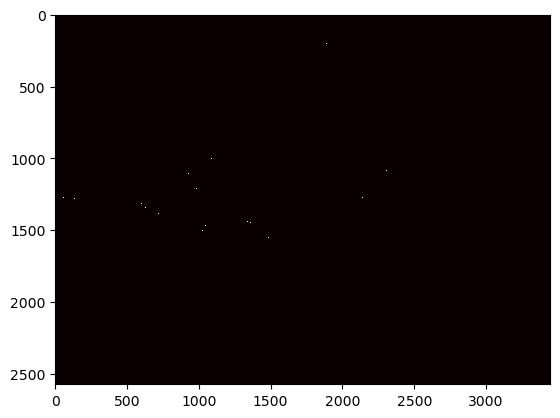

In [29]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(lwl, rf)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())


rf size expected: (1000, 1000)
rf after clearing nan's: (866, 866)
Garbage collection count: 3148


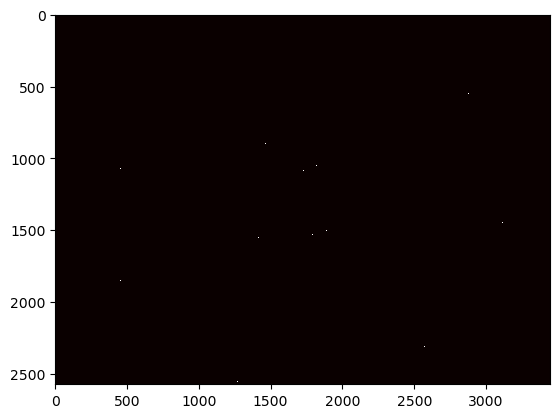

In [30]:
shadowgrapher = diag.Shadowgraphy(lwl, rf)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())


rf size expected: (1000, 1000)
rf after clearing nan's: (659, 659)
Garbage collection count: 3139


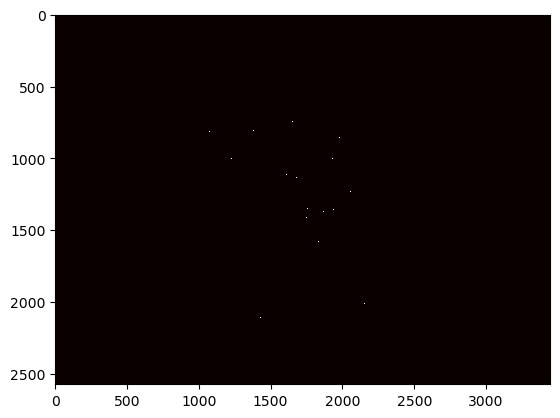

In [31]:
schlierener = diag.Schlieren(lwl, rf)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

plt.imshow(schlierener.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [32]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam



# solve ray trace
tracer = p.Propagator(domain, beam_definition.s0, probing_direction = probing_direction, inv_brems = False, phaseshift = True)

tracer.calc_dndr()
rf, Jf = tracer.solve(parallelise = False, jitted = False, return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis

interferometrer = diag.Interferometry(lwl, rf, Jf)
interferometrer.interfere_ref_beam(n_fringes, deg)

pattern = diag.Interferometry(lwl, rf, Jf)
#pattern = interferometrer
pattern.two_lens_solve()
pattern.interferogram(bin_scale = 1, clear_mem = True) #use interferogram instead of histogram

#get interferogram histogram with sh.H
plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')

72128
hi

Size in memory of initial rays: 70.4375KB
